In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
import numpy as np
import pandas as pd
import collections
import itertools
import openpyxl
import time
import copy
import psutil
import os
import re
from scipy.interpolate import interp1d
from openpyxl.styles import Font, alignment, borders
from math import sin, cos, sqrt, atan2, radians, degrees

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objs as go
import plotly

#### Define functions

In [2]:
# <editor-fold desc="generator">
def generator(beginning, ending):
    while beginning < ending:
        yield beginning
        beginning += 1
# </editor-fold>


# <editor-fold desc="Return 2 random integers within a range(start, end)">
def random(start, end):
    first, second = np.random.randint(start, end), np.random.randint(start, end)
    return first, second
# </editor-fold>


# <editor-fold desc="Generate a random rider at location (x_h, y_h) in a random home area">
def sel_home_area():
    random_home_area = np.random.choice(Home_list)
    x_h, y_h = random(0, 45)
    x_min_home_area, x_max_home_area = Home[random_home_area][0][0], Home[random_home_area][0][1]
    y_min_home_area, y_max_home_area = Home[random_home_area][1][0], Home[random_home_area][1][1]
    # Check until (x_h, y_h) stand within selected random home area
    while x_min_home_area > x_h or x_h > x_max_home_area or y_min_home_area > y_h or y_h > y_max_home_area:
        x_h, y_h = random(0, 45)
    return x_h, y_h, random_home_area
# </editor-fold>


# <editor-fold desc="Generate a random rider at location (x_w, y_w) in a random work area">
def sel_work_area():
    random_work_area = np.random.choice(Work_list)
    x_w, y_w = random(0, 45)
    x_min_work_area, x_max_work_area = Work[random_work_area][0][0], Work[random_work_area][0][1]
    y_min_work_area, y_max_work_area = Work[random_work_area][1][0], Work[random_work_area][1][1]
    # Check until (x_w, y_w) stand within selected random work area
    while x_min_work_area > x_w or x_w > x_max_work_area or y_min_work_area > y_w or y_w > y_max_work_area:
        x_w, y_w = random(0, 45)
    return x_w, y_w, random_work_area
# </editor-fold>


# <editor-fold desc="Calculate and return distance between 2 points (e.g. (x1, y1) and (x2, y2))">
def distance(node1, node2):
    return abs(node1[0]-node2[0])+abs(node1[1]-node2[1])
# </editor-fold>


# <editor-fold desc="Calculate and return distance between 2 points (e.g. (x1, y1) and (x2, y2))">
def flight_dist(node1, node2):
    return sqrt(np.square(node1[0]-node2[0]) + np.square(node1[1]-node2[1]))
# </editor-fold>


# <editor-fold desc="Removing selected taxi and riders from taxi, origin and destination dictionaries">
def del_dict_item(selected_taxi, comb_dic, index_dic):
    del Taxis_copy[selected_taxi]
    for each_rider in comb_dic[selected_taxi][index_dic[selected_taxi][0]]:
        del riders_O_copy[each_rider]
        del riders_D_copy[re.sub(r'o', 'd', each_rider)]
# </editor-fold>


# <editor-fold desc="Return traveled dist for each rider respectively, from pick up to drop off point in sharing mode">
def finding_distance_sharing(origin_list, destination_list):
    temp_lst = []  # temp_lst store traveled distance for each rider until drop off point
    sequence_pick_up_drop_off = origin_list + destination_list
    for rider in origin_list:
        rider_sequence = sequence_pick_up_drop_off[origin_list.index(rider):
                                                       sequence_pick_up_drop_off.index(re.sub(r'o', 'd', rider))+1]
        each_one_traveled_dist = 0
        for each in range(len(rider_sequence) - 1):
            if re.findall(r'[a-zA-Z]+', rider_sequence[each])[0] == 'pd':
                prior = riders_D[rider_sequence[each]]
            else:
                prior = riders_O[rider_sequence[each]]
            if re.findall(r'[a-zA-Z]+', rider_sequence[each + 1])[0] == 'pd':
                following = riders_D[rider_sequence[each + 1]]
            else:
                following = riders_O[rider_sequence[each + 1]]
            each_one_traveled_dist += distance(prior, following)
        temp_lst.append(each_one_traveled_dist)
    return temp_lst
# </editor-fold>


# <editor-fold desc="generate hex color">
def color():
    def hex():
        return np.random.randint(250)
    return '#{0:02X}{1:02X}{2:02X}'.format(hex(), hex(), hex())
# </editor-fold>



def find_angle(xyo, xyd):
    """
    xyo - Tuple (x1, y1): origin point
    xyd - Tuple (x2, y2): destination point
    return anti-clockwise angle of a given line
    """

    x1, y1 = xyo
    x2, y2 = xyd
    angle = degrees(atan2(y2-y1, x2-x1))
    if angle > 0:
        return angle
    else:
        return (angle + 360) % 360


def find_angles(first_line, second_line):
    """
    first line, second line - anti-clockwise angle of each line
    return acute angle between 2 line
    """

    difference = abs(first_line-second_line)
    if difference < 180:
        return difference
    else:
        return 360 - difference


def bisector_angle(xyo1, xyd1, xyo2, xyd2):
    """
    xyo1, xyd1 - Tuple (x1, y1) in origin (x2, y2) in destination for first line
    xyo2, xyd2 - Tuple (x1, y1) in origin (x2, y2) in destination for second line
    return anti-clockwise angle for bisector of given 2 lines
    """

    angle1 = find_angle(xyo1, xyd1)
    angle2 = find_angle(xyo2, xyd2)

    # angle1 < angle2
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1

    if (angle2 - angle1) < 180:
        angle = find_angles(angle1, angle2) / 2 + angle1
    else:
        angle = find_angles(angle1, angle2) / 2 + angle2
        if angle > 360:
            angle -= 360
    return angle


def bisector_line(point_origin, angle, length):
    """
    point_origin - Tuple (x, y) in origin
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.
    """

    # unpack the first point
    x, y = point_origin

    # find the end point
    point_destination = x+length * cos(radians(angle)), y+length * sin(radians(angle))

    # point_destination = x, y
    return point_destination

#### Input number of taxis and riders

In [3]:
# <editor-fold desc="Input number of taxis and riders">
No_Taxi = int(input('Enter #Taxi= '))
No_riders = int(input('Enter #Rider= '))
number_of_clusters = int(input('Enter number_of_clusters= '))
# </editor-fold>
path = '/home/samim/PycharmProjects/2/'

Enter #Taxi= 300
Enter #Rider= 300
Enter number_of_clusters= 5


#### create areas, riders, taxis

In [4]:
# <editor-fold desc="create areas, riders, taxis">
# ----------------------------------------------------------------------------------------------------------------------
#                                              Creating Home and Work Area
# ----------------------------------------------------------------------------------------------------------------------
Home = {}
Work = {}
area = 0
for y in range(0, 31, 15):
    y1, y2 = y, y+15
    for x in range(0, 31, 15):
        x1, x2 = x, x+15
        if area == 4 or area == 8:
            Work["w{0}".format(area+1)] = [(x1, x2), (y1, y2)]
        else:
            Home["h{0}".format(area+1)] = [(x1, x2), (y1, y2)]
        area += 1
Home_list = list(Home.keys())
Work_list = list(Work.keys())


# ----------------------------------------------------------------------------------------------------------------------
#                                                Generate Taxi Randomly
# ----------------------------------------------------------------------------------------------------------------------
Taxis = {}
for taxi in generator(1, No_Taxi+1):
    if taxi < (No_Taxi-No_Taxi/5):
        x, y, sel_home = sel_home_area()
        Taxis["t{0}".format(taxi)] = (x, y)
    else:
        x, y, sel_work = sel_work_area()
        Taxis["t{0}".format(taxi)] = (x, y)


# ----------------------------------------------------------------------------------------------------------------------
#                                                Generate Rider Randomly
# ----------------------------------------------------------------------------------------------------------------------
Riders_O = {}
riders_O = {}
riders_D = {}
person = 1
while len(riders_O) != No_riders:
    # Generate /--one fifth--/ of #riders work to home
    if person > int(No_riders * (1-1/5)):
        x, y, sel_work = sel_work_area()
        xx, yy, sel_home = sel_home_area()
        if distance((x, y), (xx, yy)) > 10:
            Riders_O["p{0}_".format(person) + sel_work + '_to_' + sel_home] = (x, y)  # Origin_to_Destination
            riders_O["po{0}".format(person)] = (x, y)  # Origin
            riders_D["pd{0}".format(person)] = (xx, yy)  # Destination
            person += 1

    # Generate /--one fifth--/ of (#riders*(4 / 5) home to home
    elif person > int(No_riders * (1-1/5)**2):
        x, y, sel_home = sel_home_area()
        xx, yy, sel_home_sec = sel_home_area()
        while sel_home_sec == sel_home:
            xx, yy, sel_home_sec = sel_home_area()
        if distance((x, y), (xx, yy)) > 10:
            Riders_O["p{0}_".format(person) + sel_home + '_to_' + sel_home_sec] = (x, y)  # Origin_to_Destination
            riders_O["po{0}".format(person)] = (x, y)  # Origin
            riders_D["pd{0}".format(person)] = (xx, yy)  # Destination
            person += 1

    # Generate /--#riders*(4 / 5)--/ of #riders home to work
    elif person > 0:
        x, y, sel_home = sel_home_area()
        xx, yy, sel_work = sel_work_area()
        if distance((x, y), (xx, yy)) > 10:
            Riders_O["p{0}_".format(person) + sel_home + '_to_' + sel_work] = (x, y)  # Origin_to_Destination
            riders_O["po{0}".format(person)] = (x, y)  # Origin
            riders_D["pd{0}".format(person)] = (xx, yy)  # Destination
            person += 1
# </editor-fold>


#### Plotting

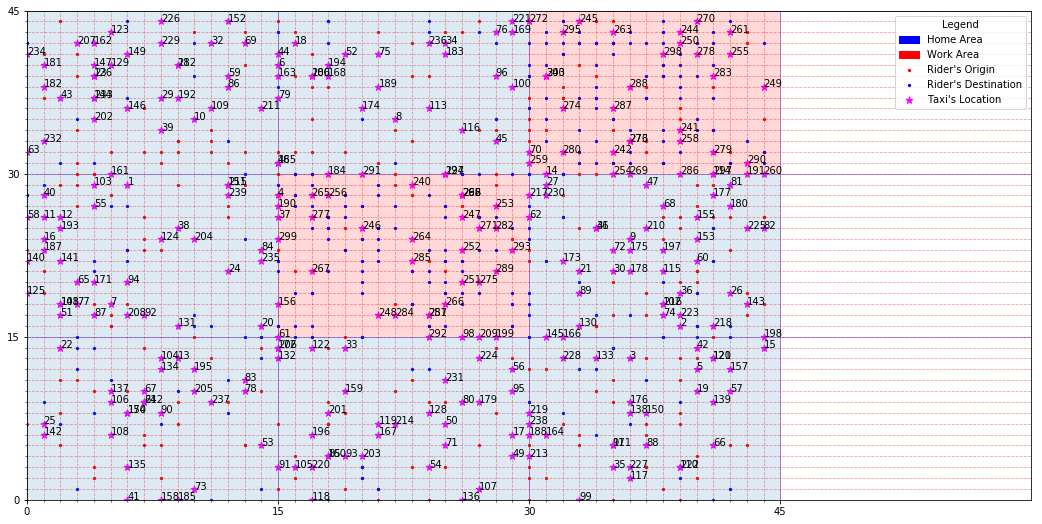

In [5]:
# <editor-fold desc="plot body 1">
# ----------------------------------------------------------------------------------------------------------------------
#                                                        Plotting
# ----------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(18,9))

alpha = [1.9, .6, .25, .15]
patterns = ['+', 'x', '-']
for each_area in generator(1, 10):
    if each_area == 5 or each_area == 9:
        x, y, w, h = Work["w{0}".format(each_area)][0][0], \
                     Work["w{0}".format(each_area)][1][0], \
                     Work["w{0}".format(each_area)][0][1] - Work["w{0}".format(each_area)][0][0], \
                     Work["w{0}".format(each_area)][1][1] - Work["w{0}".format(each_area)][1][0]
        rect = patches.Rectangle((x, y), w, h, facecolor='red', alpha=alpha[3], )
        ax.add_patch(rect)
    else:
        x, y, w, h = Home["h{0}".format(each_area)][0][0], \
                     Home["h{0}".format(each_area)][1][0], \
                     Home["h{0}".format(each_area)][0][1]-Home["h{0}".format(each_area)][0][0], \
                     Home["h{0}".format(each_area)][1][1]-Home["h{0}".format(each_area)][1][0]
        rect = patches.Rectangle((x, y), w, h, alpha=alpha[3], )
        ax.add_patch(rect)


# 1 scatter plot with different text at each data point
i = 0
numbers = np.arange(1, No_Taxi+1)
for x, y in list(Taxis.values()):
    ax.text(x, y, numbers[i])
    i += 1


ax.axis([0, 60, 0, 45])
ax.minorticks_on()

ax.grid(b=True, which="minor", linestyle="--", color='r', alpha=0.4)
ax.grid(b=True, which="major", linestyle="-", linewidth=1, color="b", alpha=0.4)

ax.set_axisbelow(True)
ax.set_xticks(np.arange(0, 46, 15))
ax.set_yticks(np.arange(0, 46, 15))
ax.set_xticks(np.arange(0, 46, 1), minor=True)
ax.set_yticks(np.arange(0, 46, 1), minor=True)

blue_patch = patches.Patch(color='blue', label="Home Area")
red_patch = patches.Patch(color='red', label="Work Area")
red_dot = ax.scatter(*zip(*list(Riders_O.values())), marker='.', c='r', s=20, label="Rider's Origin")
blue_dot = ax.scatter(*zip(*list(riders_D.values())), marker='.', c='blue', s=20, label="Rider's Destination")
green_star = ax.scatter(*zip(*list(Taxis.values())), marker='*', c='fuchsia', s=50, label="Taxi's Location")

ax.legend(handles=[blue_patch, red_patch, red_dot, blue_dot, green_star], loc='best', title='Legend')
# </editor-fold>

#### Define variables

In [6]:
SIF_list = np.linspace(1, 2.4, 15)
# <editor-fold desc="define variables">
riders, Zeros, Ones, Twos, Threes, Fours = [], [], [], [], [], []
vkt_Share, vkt_ShareSingle, vkt_rejected = [], [], []
# </editor-fold>

# <editor-fold desc="Create text file for writing print lines">
file = open(path+'log.txt', 'w')
# Writing in log.txt file
file.write('{0}\n\n{1}\n\n{2}\n\n{3}\n\n'.format(Riders_O, riders_O, riders_D, Taxis))
# </editor-fold>

# <editor-fold desc="Create excel file for results (output.xlsx)">
excel_writer = pd.ExcelWriter(path+'output.xlsx')
# </editor-fold>

# <editor-fold desc="summary of sif sheet in active_cars">
# Data frame for active cars in network
df_active_cars = pd.DataFrame(columns=['#zero',
                                       '#one',
                                       '#two',
                                       '#three',
                                       '#four',
                                       'Sum_taxi',
                                       'Sum_rider',
                                       'Nan+One',
                                       'Missing',
                                       'Total'])
# </editor-fold>


#### Senario Base

In [7]:
# <editor-fold desc="Distance based on individual mode(each rider travel with own vehicle)">
vkt_base = {}
for each_person in riders_O:
    vkt_base[each_person] = distance(riders_O[each_person], riders_D[re.sub(r'o', 'd', each_person)])
vkt_base = [sum(vkt_base.values())]*len(SIF_list)
vkt_base
# </editor-fold>

[9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499,
 9499]

#### Senario 1

In [8]:
senario_df = pd.DataFrame(index=riders_O.keys(),columns=Taxis.keys(), dtype='float64')
for each_person in riders_O:
    each_row = []
    for each_taxi in Taxis:
        dist = distance(Taxis[each_taxi], riders_O[each_person])
        each_row.append(dist)
    senario_df.loc[each_person,:] = each_row

vkt_single = 0
for _ in senario_df.iterrows():
    row, col = senario_df.stack().idxmin()
    
    vkt_single += senario_df.loc[row,col]
    vkt_single += distance(riders_O[row], riders_D[re.sub(r'o', 'd', row)])
    
    senario_df.drop(index=row,columns=col,inplace=True)

vkt_single = [vkt_single]*len(SIF_list)
vkt_single

[10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0,
 10857.0]

#### Senario 2

In [9]:
senario_df = pd.DataFrame(index=riders_O.keys(),columns=Taxis.keys(), dtype='float64')
for each_person in riders_O:
    each_row = []
    for each_taxi in Taxis:
        dist = distance(Taxis[each_taxi], riders_O[each_person])
        each_row.append(dist)
    senario_df.loc[each_person,:] = each_row

vkt_without_comb = 0
Taxis_sen2, riders_O_sen2, riders_D_sen2 = Taxis.copy(), riders_O.copy(), riders_D.copy()
for _ in senario_df.iterrows():
    taxi_group = {each_taxi:senario_df.sort_values(by=each_taxi)[each_taxi][:4].sum() 
                  for each_taxi in Taxis_sen2.keys()}
    min_taxi = min(taxi_group, key=taxi_group.get)
    min_rider = senario_df.sort_values(by=min_taxi)[min_taxi][:4].index.tolist()
    
    
    if len(min_rider)<4:
        pass
    else:
        # -----------------------------------------------------------------------------------------------------
        #                                       Shortest path (Start)
        # -----------------------------------------------------------------------------------------------------
        # path_finding dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
        path_finding = collections.defaultdict(list)
        # Find chosen combination from comb dictionary
        chosen_rider = min_rider
        for each_key in chosen_rider:
            path_finding[1].append(each_key)
            path_finding[2].append(re.sub(r'o', 'd', each_key))

        # Find permutation of riders for chosen taxi in both origin and destination
        path_finding_permutation = collections.defaultdict(list)
        for i in path_finding:
            for j in itertools.permutations(path_finding[i]):
                path_finding_permutation[i].append(j)

        # Calculating traveled distance for each permutation in ======================================== origin
        # path_finding_permutation_dist = {1:[]}
        path_finding_permutation_dist = collections.defaultdict(list)
        for j in range(len(path_finding_permutation[1])):
            sum_dist = 0
            for k in range(len(path_finding_permutation[1][j]) - 1):
                sum_dist += distance(riders_O_sen2[path_finding_permutation[1][j][k]],
                                     riders_O_sen2[path_finding_permutation[1][j][k + 1]])
            path_finding_permutation_dist[1].append(sum_dist +
                                                    distance(Taxis_sen2[min_taxi],
                                                             riders_O_sen2[path_finding_permutation[1][j][0]]))

        # -----------------------------------------------------------------------------------------------------
        # -----------------------------------------------------------------------------------------------------
        # Calculating traveled distance for each permutation in destination based on origin permutations
        # that are in path_finding_permutation[1] list, i.e. we try all origin sequence to get minimum distance
        # path_finding_permutation_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
        for i in range(len(path_finding_permutation[1])):
            list_temporary = []
            # Calculating traveled distance for each permutation in =============================== destination
            for j in range(len(path_finding_permutation[2])):
                sum_dist = 0
                for k in range(len(path_finding_permutation[2][j]) - 1):
                    sum_dist += distance(riders_D_sen2[path_finding_permutation[2][j][k]],
                                         riders_D_sen2[path_finding_permutation[2][j][k + 1]])
                dist_in_o = path_finding_permutation_dist[1][i]
                list_temporary.append(sum_dist + distance(riders_O_sen2[path_finding_permutation[1][i][3]],
                                                          riders_D_sen2[path_finding_permutation[2][j][0]]) 
                                      + dist_in_o)
            path_finding_permutation_dist[2].append(list_temporary)

        # I don't care how many minimum are in each list of key(2):[  ] of path_finding_permutation_dist?
        # We have minimum in destination per origin, min_2 = [number of permutation in origin]
        min_2 = [min(path_finding_permutation_dist[2][i]) for i in range(len(path_finding_permutation_dist[2]))]

        # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
        index_min_1 = min_2.index(min(min_2))
        path_min_1 = path_finding_permutation[1][index_min_1]
        min_1 = path_finding_permutation_dist[1][index_min_1]

        # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
        # Return rider's destination sequence in path_min_2 as a list
        index_min_2 = path_finding_permutation_dist[2][index_min_1].\
            index(min(path_finding_permutation_dist[2][index_min_1]))
        path_min_2 = path_finding_permutation[2][index_min_2]

        vkt_without_comb += min(min_2)

        senario_df.drop(index=min_rider,columns=min_taxi,inplace=True)
        del Taxis_sen2[min_taxi]
_sum_extra = 0
for _ in senario_df.iterrows():
    row, col = senario_df.stack().idxmin()
    _sum_extra += senario_df.loc[row,col]
    _sum_extra += distance(riders_O[row], riders_D[re.sub(r'o', 'd', row)])
    senario_df.drop(index=row,columns=col,inplace=True)

vkt_without_comb = [vkt_without_comb+_sum_extra]*len(SIF_list)
vkt_without_comb

[6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417,
 6417]

In [10]:
# # without combination
# Taxis_without_comb, riders_O_without_comb, riders_D_without_comb = \
# Taxis.copy(), riders_O.copy(), riders_D.copy()

# taxi_catchment = collections.defaultdict(list)
# for j in Taxis_without_comb:
#     catchment_area = patches.Circle(Taxis_without_comb[j], radius=5)
#     for each_person in riders_O_without_comb:
#         if catchment_area.contains_point(riders_O_without_comb[each_person]):
#             taxi_catchment[j].append(each_person)

# duplicate_key = set()
# taxi_key = list(taxi_catchment.keys())
# for _ in range(len(taxi_key)):
#     for __ in range(_+1,len(taxi_key)):
#         if taxi_catchment[taxi_key[_]] == taxi_catchment[taxi_key[__]]:
#             duplicate_key.add(taxi_key[__])  
# for _ in duplicate_key:
#     del taxi_catchment[_]


# _ = {}
# for each_taxii in taxi_catchment:
#     _sum, _lis = 0, []
#     for each_rid in taxi_catchment[each_taxii]:
#         if each_rid in riders_O_without_comb:
#             _lis.append(each_rid)
#     _lis = _lis[:4]
#     if _lis:
#         for each_rid_index in range(len(_lis)-1):
#             _sum += distance(riders_O_without_comb[_lis[each_rid_index]], 
#                              riders_O_without_comb[_lis[each_rid_index+1]])
#             _sum += distance(riders_D_without_comb[re.sub(r'o', 'd', _lis[each_rid_index])], 
#                              riders_D_without_comb[re.sub(r'o', 'd', _lis[each_rid_index+1])])
#         _sum += distance(Taxis_without_comb[each_taxii], riders_O_without_comb[_lis[0]])
#         _sum += distance(riders_O_without_comb[_lis[-1]], riders_D_without_comb[re.sub(r'o', 'd', _lis[0])])
#     else:
#         pass
#     _[each_taxii] = _sum
#     for i in _lis:
#         del riders_O_without_comb[i]

# _sum_extra = 0
# for each_per in riders_O_without_comb:
#     _sum_extra += distance(riders_O[each_per], riders_D[re.sub(r'o', 'd', each_per)]) 
    
# vkt_without_comb = [sum(_.values())+_sum_extra]*len(SIF_list)
# vkt_without_comb

## Main Body

In [11]:
share_single_list, rejected_request = [], []
Start = time.time()
# For loop to find optimum SIF ============================================== Sharing importance factor == SIF
for SIF in [round(_, 1) for _ in SIF_list]:
    # Writing in log.txt file
    file.write((('\n\n*\n*\n SIF = {0}\n*\n*\n'.format(SIF)).replace(' ', ' ' * 40, 1)).replace('*', '*' * 100, 4))

    # <editor-fold desc="sheet for each sif">
    # Data frame for results - selected taxi and so on
    df = pd.DataFrame(columns=['Taxi',
                               'Sequence at the origin', 'Sequence at the destination',
                               'to first rider', 'origin', 'transfer', 'destination',
                               '(Sharing)', ' ', ' ', ' ',
                               '(Single)', ' ', ' ', ' ',
                               'Sharing/Single', ' ', ' ', ' '])
    df.loc[' '] = [' ',
                   ' ', ' ',
                   ' ', ' ', ' ', ' ',
                   'P1', 'P2', 'P3', 'P4',
                   'P1', 'P2', 'P3', 'P4',
                   'P1', 'P2', 'P3', 'P4']
    # </editor-fold>

    # <editor-fold desc="define variables">
    # For each SIF we should Retrieve Taxis, riders_O and riders_D dictionaries
    Taxis_copy, riders_O_copy, riders_D_copy = Taxis.copy(), riders_O.copy(), riders_D.copy()
    zeros_, ones_, twos_, threes_, fours_ = 0, 0, 0, 0, 0  # Number of taxis with this riders
    vkt_share = {}  # Distance each taxi travel in sharing mode
    rejected_rider = []
    share_single_value = 0
    # </editor-fold>

    # Check all taxis
    for each_taxi in generator(0, len(Taxis)):
        file.write((('\n=\n taxi index {} \n'.format(each_taxi)).
                            replace(' ', ' ' * 40, 1)).replace('=', '=' * 100, 2))
        check = True  # Check if there is at least one taxi in comb_locO_com_cons_min dictionary
        check_3 = True  # Check if there is at least one taxi in comb_locO_com_cons_min_3 dictionary
        # Writing in log.txt file
        # file.write((('\n\n*\n Taxi = {}\n'.format(each_taxi+1)).replace(' ', ' ' * 40, 1)).replace('*', '*' * 100, 2))

        # <editor-fold desc="if rider be in taxis's catchment area, it will be in taxi's list">
        taxi_catchment = collections.defaultdict(list)
        for j in Taxis_copy:
            catchment_area = patches.Circle(Taxis_copy[j], radius=5)
            for each_person in riders_O_copy:
                if catchment_area.contains_point(riders_O_copy[each_person]):
                    taxi_catchment[j].append(each_person)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('taxi_catchment', dict(taxi_catchment)))
        # </editor-fold>
        
        duplicate_key = set()
        taxi_key = list(taxi_catchment.keys())
        for _ in range(len(taxi_key)):
            for __ in range(_+1,len(taxi_key)):
                if taxi_catchment[taxi_key[_]] == taxi_catchment[taxi_key[__]]:
                    duplicate_key.add(taxi_key[__])  
        for _ in duplicate_key:
            del taxi_catchment[_]
            
            
        # <editor-fold desc="4-combination">
        # --------------------------------------------------------------------------------------------------------------
        #                                                   4
        # --------------------------------------------------------------------------------------------------------------
        # Find 4-combination of riders for each taxi
        comb = collections.defaultdict(list)
        for i in taxi_catchment:
            if len(taxi_catchment[i]) >= 4:
                for j in itertools.combinations(taxi_catchment[i], 4):
                    comb[i].append(j)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb', dict(comb)))

        # Origin 4-coordinates (from rider_O dictionary) for 4-combination of riders for each taxi
        comb_locO = collections.defaultdict(list)
        for i in comb:
            for j in range(len(comb[i])):
                list_temporary = []
                for k in range(len(comb[i][j])):
                    list_temporary.append(riders_O_copy[comb[i][j][k]])
                comb_locO[i].append(list_temporary)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO', dict(comb_locO)))

        # Destination 4-coordinates (from rider_D dictionary) for 4-combination of riders for each taxi
        comb_locD = collections.defaultdict(list)
        for i in comb:
            for j in range(len(comb[i])):
                list_temporary = []
                for k in range(len(comb[i][j])):
                    list_temporary.append(riders_D_copy[re.sub(r'o', 'd', comb[i][j][k])])
                comb_locD[i].append(list_temporary)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locD', dict(comb_locD)))

        # Calculating center of points for each group of riders for each taxi in origin
        comb_locO_com = collections.defaultdict(list)
        for i in comb_locO:
            comb_locO_com[i].append((np.array(comb_locO[i]).mean(axis=1)).tolist())
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com', dict(comb_locO_com)))

        # Calculating center of points for each group of riders for each taxi in destination
        comb_locD_com = collections.defaultdict(list)
        for i in comb_locO:
            comb_locD_com[i].append((np.array(comb_locD[i]).mean(axis=1)).tolist())
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locD_com', dict(comb_locD_com)))

        # --------------------------------------------------------------------------------------------------------------
        #                   Calculating constraints (const_origin + const_taxi + const_destination)
        # --------------------------------------------------------------------------------------------------------------
        comb_locO_com_cons = collections.defaultdict(list)
        for i in comb_locO_com:
            for j in range(len(comb_locO[i])):
                Constraint = 0
                for k in range(len(comb_locO[i][j])):
                    Constraint += flight_dist(comb_locO_com[i][0][j], comb_locO[i][j][k]) + \
                                  flight_dist(comb_locD_com[i][0][j], comb_locD[i][j][k])
                comb_locO_com_cons[i].append(Constraint + flight_dist(comb_locO_com[i][0][j], Taxis_copy[i]))
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons', dict(comb_locO_com_cons)))

        # Minimum values of Constraints
        comb_locO_com_cons_min = collections.defaultdict(list)
        for i in comb_locO_com_cons:
            comb_locO_com_cons_min[i].append(min(comb_locO_com_cons[i]))
        # If comb_locO_com_cons dictionary be empty then comb_locO_com_cons_min will be empty
        # i.e. minimum calculating get ValueError so we can't calculate four in Comparison minimum of 3 and 4 riders
        try:
            minimum = min(comb_locO_com_cons_min, key=comb_locO_com_cons_min.get) #taxi's num
            # Writing in log.txt file
            # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons_min', dict(comb_locO_com_cons_min)))
            file.write('{0:41} ::= {1}\n'.format('4', minimum))
        except ValueError:
            check = False

        # Index of minimum values of Constraints
        comb_locO_com_cons_min_index = collections.defaultdict(list)
        for i in comb_locO_com_cons:
            index = comb_locO_com_cons[i].index(min(comb_locO_com_cons[i]))
            comb_locO_com_cons_min_index[i].append(index)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons_min_index', dict(comb_locO_com_cons_min_index)))
        # </editor-fold>

        # <editor-fold desc="3-combination">
        # --------------------------------------------------------------------------------------------------------------
        #                                                  3
        # --------------------------------------------------------------------------------------------------------------
        # Find 3-combination of riders for each taxi
        comb_3 = collections.defaultdict(list)
        for i in taxi_catchment:
            if len(taxi_catchment[i]) >= 3:
                for j in itertools.combinations(taxi_catchment[i], 3):
                    comb_3[i].append(j)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_3', dict(comb_3)))

        # Origin 3-coordinates (from rider_O dictionary) for 3-combination of riders for each taxi
        comb_locO_3 = collections.defaultdict(list)
        for i in comb_3:
            for j in range(len(comb_3[i])):
                list_temporary = []
                for k in range(len(comb_3[i][j])):
                    list_temporary.append(riders_O_copy[comb_3[i][j][k]])
                comb_locO_3[i].append(list_temporary)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_3', dict(comb_locO_3)))

        # Destination 3-coordinates (from rider_D dictionary) for 3-combination of riders for each taxi
        comb_locD_3 = collections.defaultdict(list)
        for i in comb_3:
            for j in range(len(comb_3[i])):
                list_temporary = []
                for k in range(len(comb_3[i][j])):
                    list_temporary.append(riders_D_copy[re.sub(r'o', 'd', comb_3[i][j][k])])
                comb_locD_3[i].append(list_temporary)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locD_3', dict(comb_locD_3)))

        # Calculating center of points for each group of riders for each taxi in origin
        comb_locO_com_3 = collections.defaultdict(list)
        for i in comb_locO_3:
            comb_locO_com_3[i].append((np.array(comb_locO_3[i]).mean(axis=1)).tolist())
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_3', dict(comb_locO_com_3)))

        # Calculating center of points for each group of riders for each taxi in destination
        comb_locD_com_3 = collections.defaultdict(list)
        for i in comb_locO_3:
            comb_locD_com_3[i].append((np.array(comb_locD_3[i]).mean(axis=1)).tolist())
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locD_com_3', dict(comb_locD_com_3)))

        # --------------------------------------------------------------------------------------------------------------
        #                   Calculating constraints_3 (const_origin + const_taxi + const_destination)
        # --------------------------------------------------------------------------------------------------------------
        comb_locO_com_cons_3 = collections.defaultdict(list)
        for i in comb_locO_com_3:
            for j in range(len(comb_locO_3[i])):
                Constraint = 0
                for k in range(len(comb_locO_3[i][j])):
                    Constraint += flight_dist(comb_locO_com_3[i][0][j], comb_locO_3[i][j][k]) + \
                                 flight_dist(comb_locD_com_3[i][0][j], comb_locD_3[i][j][k])
                # ================================================================================================== SIF
                comb_locO_com_cons_3[i].append(SIF*(Constraint + flight_dist(comb_locO_com_3[i][0][j], Taxis_copy[i])))
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons_3', dict(comb_locO_com_cons_3)))

        # Minimum values of Constraints_3
        comb_locO_com_cons_min_3 = collections.defaultdict(list)
        for i in comb_locO_com_cons_3:
            comb_locO_com_cons_min_3[i].append(min(comb_locO_com_cons_3[i]))
        # If comb_locO_com_cons_3 dictionary be empty then comb_locO_com_cons_min_3 will be empty
        # i.e. minimum_3 calculating get ValueError so we can't calculate three in Comparison minimum of 3 and 4 riders
        try:
            minimum_3 = min(comb_locO_com_cons_min_3, key=comb_locO_com_cons_min_3.get)
            # Writing in log.txt file
            # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons_min_3', dict(comb_locO_com_cons_min_3)))
            file.write('{0:41} ::= {1}\n'.format('3', minimum_3))
        except ValueError:
            check_3 = False

        # Index of minimum values of Constraints_3
        comb_locO_com_cons_min_index_3 = collections.defaultdict(list)
        for i in comb_locO_com_cons_3:
            index = comb_locO_com_cons_3[i].index(min(comb_locO_com_cons_3[i]))
            comb_locO_com_cons_min_index_3[i].append(index)
        # Writing in log.txt file
        # file.write('{0:41} ::= {1}\n'.format('comb_locO_com_cons_min_index_3', dict(comb_locO_com_cons_min_index_3)))
        # </editor-fold>

        # <editor-fold desc="terminate the SIF loop">
        # --------------------------------------------------------------------------------------------------------------
        # If comb_locO_com_cons and comb_locO_com_cons_3 dictionaries be empty then terminate loop
        # i.e. if there are no riders in catchment area of any taxis then stop this loop and go for new SIF
        if not bool(comb_locO_com_cons) and not bool(comb_locO_com_cons_3):
            # Writing in log.txt file
            file.write('\n{}\n\n'.format('There is no possible taxi to choose.'))
            break
        # </editor-fold>

        # <editor-fold desc="Comparison minimum of 3 and 4 riders">
        # --------------------------------------------------------------------------------------------------------------
        #                                  Comparison minimum of 3 and 4 riders
        # --------------------------------------------------------------------------------------------------------------
        try:
            four = comb_locO_com_cons[minimum][comb_locO_com_cons_min_index[minimum][0]] / 4
        except (IndexError, NameError):
            four = 1000
        try:
            three = comb_locO_com_cons_3[minimum_3][comb_locO_com_cons_min_index_3[minimum_3][0]] / 3
        except (IndexError, NameError):
            three = 1000
        # Writing in log.txt file
        file.write('{0:41} ::= {1}\n'.format('four', four))
        file.write('{0:41} ::= {1}\n'.format('three', three))
        # </editor-fold>

        # We want to know do we have any taxi with 4 riders, by boolean operator (check)
        if four <= three and check:
            # <editor-fold desc="if four choose">
            # Writing in log.txt file
            file.write('Taxi {0} is chosen with 4 rider.\n'.format(minimum))
            fours_ += 1

            # ----------------------------------------------------------------------------------------------------------
            #                                       Shortest path (Start)
            # ----------------------------------------------------------------------------------------------------------
            # path_finding dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
            path_finding = collections.defaultdict(list)
            # Find chosen combination from comb dictionary
            chosen_rider = comb[minimum][comb_locO_com_cons_min_index[minimum][0]]
            for each_key in chosen_rider:
                path_finding[1].append(each_key)
                path_finding[2].append(re.sub(r'o', 'd', each_key))
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding', path_finding))

            # Find permutation of riders for chosen taxi in both origin and destination
            path_finding_permutation = collections.defaultdict(list)
            for i in path_finding:
                for j in itertools.permutations(path_finding[i]):
                    path_finding_permutation[i].append(j)
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding_permutation', path_finding_permutation))

            # Calculating traveled distance for each permutation in ============================================= origin
            # path_finding_permutation_dist = {1:[]}
            path_finding_permutation_dist = collections.defaultdict(list)
            for j in range(len(path_finding_permutation[1])):
                sum_dist = 0
                for k in range(len(path_finding_permutation[1][j]) - 1):
                    sum_dist += distance(riders_O_copy[path_finding_permutation[1][j][k]],
                                         riders_O_copy[path_finding_permutation[1][j][k + 1]])
                path_finding_permutation_dist[1].append(sum_dist +
                                                        distance(Taxis_copy[minimum],
                                                                 riders_O_copy[path_finding_permutation[1][j][0]]))

            # ----------------------------------------------------------------------------------------------------------
            # ----------------------------------------------------------------------------------------------------------
            # Calculating traveled distance for each permutation in destination based on origin permutations
            # that are in path_finding_permutation[1] list, i.e. we try all origin sequence to get minimum distance
            # path_finding_permutation_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
            for i in range(len(path_finding_permutation[1])):
                list_temporary = []
                # Calculating traveled distance for each permutation in ==================================== destination
                for j in range(len(path_finding_permutation[2])):
                    sum_dist = 0
                    for k in range(len(path_finding_permutation[2][j]) - 1):
                        sum_dist += distance(riders_D_copy[path_finding_permutation[2][j][k]],
                                             riders_D_copy[path_finding_permutation[2][j][k + 1]])
                    dist_in_o = path_finding_permutation_dist[1][i]
                    list_temporary.append(sum_dist + distance(riders_O_copy[path_finding_permutation[1][i][3]],
                                                              riders_D_copy[path_finding_permutation[2][j][0]])
                                          + dist_in_o)
                path_finding_permutation_dist[2].append(list_temporary)
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding_permutation_dist', path_finding_permutation_dist))

            # I don't care how many minimum are in each list of key(2):[  ] of path_finding_permutation_dist?
            # We have minimum in destination per origin, min_2 = [number of permutation in origin]
            min_2 = [min(path_finding_permutation_dist[2][i]) for i in range(len(path_finding_permutation_dist[2]))]

            # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
            index_min_1 = min_2.index(min(min_2))
            path_min_1 = path_finding_permutation[1][index_min_1]
            min_1 = path_finding_permutation_dist[1][index_min_1]

            # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
            # Return rider's destination sequence in path_min_2 as a list
            index_min_2 = path_finding_permutation_dist[2][index_min_1].\
                index(min(path_finding_permutation_dist[2][index_min_1]))
            path_min_2 = path_finding_permutation[2][index_min_2]

            # ----------------------------------------------------------------------------------------------------------
            #                                       Put results in df (Data Frame)
            # ----------------------------------------------------------------------------------------------------------
            to_first_rider = distance(Taxis_copy[minimum], riders_O[path_min_1[0]])
            origin = min_1 - distance(Taxis_copy[minimum], riders_O[path_min_1[0]])
            transfer = distance(riders_O[path_min_1[3]], riders_D[path_min_2[0]])
            destination = min(min_2) - transfer - min_1

            p1_share, p2_share, p3_share, p4_share = finding_distance_sharing(path_min_1, path_min_2)

            p1_individual = distance(riders_O_copy[path_min_1[0]], riders_D_copy[re.sub(r'o', 'd', path_min_1[0])])
            p2_individual = distance(riders_O_copy[path_min_1[1]], riders_D_copy[re.sub(r'o', 'd', path_min_1[1])])
            p3_individual = distance(riders_O_copy[path_min_1[2]], riders_D_copy[re.sub(r'o', 'd', path_min_1[2])])
            p4_individual = distance(riders_O_copy[path_min_1[3]], riders_D_copy[re.sub(r'o', 'd', path_min_1[3])])

            # Share mode over individual mode for all chosen riders
            lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
            lst2 = np.array([p1_individual, p2_individual, p3_individual, p4_individual], dtype='float')
            divide = lst1 / lst2
            divide[divide > 2] = np.NaN
            so1, so2, so3, so4 = divide

            # number_of_non_NaN_value = np.count_nonzero(~np.isnan(divide))
            number_of_NaN_value = np.count_nonzero(np.isnan(divide))

            # nan rider
            index_of_Nan = [i[0] for i in np.argwhere(np.isnan(divide)).tolist()]
            [rejected_rider.append(path_min_1[i]) for i in index_of_Nan]
            index_of_non_Nan = [i[0] for i in np.argwhere(~np.isnan(divide)).tolist()]

            if number_of_NaN_value == 3 or number_of_NaN_value == 4:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                fours_ -= 1
                if number_of_NaN_value == 3:
                    [rejected_rider.append(path_min_1[i]) for i in index_of_non_Nan]
                    ones_ += 1
                else:
                    zeros_ += 1
                pass
            elif number_of_NaN_value == 2 or number_of_NaN_value == 1:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                fours_ -= 1
                if number_of_NaN_value == 2:
                    twos_ += 1
                else:
                    threes_ += 1
                chosen_rider = [path_min_1[i] for i in index_of_non_Nan]
                # ------------------------------------------------------------------------------------------------------
                #                                       2_Shortest path (Start)
                # ------------------------------------------------------------------------------------------------------
                # path_finding dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
                path_finding = collections.defaultdict(list)
                # Find chosen combination from comb dictionary
                for each_key in chosen_rider:
                    path_finding[1].append(each_key)
                    path_finding[2].append(re.sub(r'o', 'd', each_key))
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding', path_finding))

                # Find permutation of riders for chosen taxi in both origin and destination
                path_finding_permutation = collections.defaultdict(list)
                for i in path_finding:
                    for j in itertools.permutations(path_finding[i]):
                        path_finding_permutation[i].append(j)
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding_permutation', path_finding_permutation))

                # Calculating traveled distance for each permutation in ========================================= origin
                # path_finding_permutation_dist = {1:[]}
                path_finding_permutation_dist = collections.defaultdict(list)
                for j in range(len(path_finding_permutation[1])):
                    sum_dist = 0
                    for k in range(len(path_finding_permutation[1][j]) - 1):
                        sum_dist += distance(riders_O_copy[path_finding_permutation[1][j][k]],
                                             riders_O_copy[path_finding_permutation[1][j][k + 1]])
                    path_finding_permutation_dist[1].append(sum_dist +
                                                            distance(Taxis_copy[minimum],
                                                                     riders_O_copy[path_finding_permutation[1][j][0]]))
                # ------------------------------------------------------------------------------------------------------
                # ------------------------------------------------------------------------------------------------------
                # Calculating traveled distance for each permutation in destination based on origin permutations
                # that are in path_finding_permutation[1] list, i.e. we try all origin sequence to get minimum distance
                # path_finding_permutation_dist = {1:[],
                #                                  2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
                for i in range(len(path_finding_permutation[1])):
                    list_temporary = []
                    # Calculating traveled distance for each permutation in ================================ destination
                    for j in range(len(path_finding_permutation[2])):
                        sum_dist = 0
                        for k in range(len(path_finding_permutation[2][j]) - 1):
                            sum_dist += distance(riders_D_copy[path_finding_permutation[2][j][k]],
                                                 riders_D_copy[path_finding_permutation[2][j][k + 1]])
                        if number_of_NaN_value == 2:
                            dist_in_o = path_finding_permutation_dist[1][i]
                            list_temporary.append(sum_dist + distance(riders_O_copy[path_finding_permutation[1][i][1]],
                                                                      riders_D_copy[path_finding_permutation[2][j][0]]) 
                                                  + dist_in_o)
                        elif number_of_NaN_value == 1:
                            dist_in_o = path_finding_permutation_dist[1][i]
                            list_temporary.append(sum_dist + distance(riders_O_copy[path_finding_permutation[1][i][2]],
                                                                      riders_D_copy[path_finding_permutation[2][j][0]]) 
                                                  + dist_in_o)
                    path_finding_permutation_dist[2].append(list_temporary)
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding_permutation_dist', path_finding_permutation_dist))

                # I don't care how many minimum are in each list of key(2):[  ] of path_finding_permutation_dist?
                # We have minimum in destination per origin's, min_2 = [number of permutation in origin]
                min_2 = [min(path_finding_permutation_dist[2][i]) for i in range(len(path_finding_permutation_dist[2]))]

                # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
                index_min_1 = min_2.index(min(min_2))
                path_min_1 = path_finding_permutation[1][index_min_1]
                min_1 = path_finding_permutation_dist[1][index_min_1]

                # Getting index of permutation that its traveled distance in (destination + origin) become the lowest
                # and Return rider's destination sequence in path_min_2 as a list
                index_min_2 = path_finding_permutation_dist[2][index_min_1].\
                    index(min(path_finding_permutation_dist[2][index_min_1]))
                path_min_2 = path_finding_permutation[2][index_min_2]

                # ------------------------------------------------------------------------------------------------------
                #                                       Put results in df (Data Frame)
                # ------------------------------------------------------------------------------------------------------
                to_first_rider = distance(Taxis_copy[minimum], riders_O[path_min_1[0]])
                origin = min_1 - distance(Taxis_copy[minimum], riders_O[path_min_1[0]])
                if number_of_NaN_value == 2:
                    transfer = distance(riders_O[path_min_1[1]], riders_D[path_min_2[0]])

                    p1_share, p2_share = finding_distance_sharing(path_min_1, path_min_2)
                    p3_share = np.NaN
                    p4_share = np.NaN

                    p1_individual = distance(riders_O_copy[path_min_1[0]],
                                             riders_D_copy[re.sub(r'o', 'd', path_min_1[0])])
                    p2_individual = distance(riders_O_copy[path_min_1[1]],
                                             riders_D_copy[re.sub(r'o', 'd', path_min_1[1])])
                    p3_individual = np.NaN
                    p4_individual = np.NaN
                elif number_of_NaN_value == 1:
                    transfer = distance(riders_O[path_min_1[2]], riders_D[path_min_2[0]])

                    p1_share, p2_share, p3_share = finding_distance_sharing(path_min_1, path_min_2)
                    p4_share = np.NaN

                    p1_individual = distance(riders_O_copy[path_min_1[0]],
                                             riders_D_copy[re.sub(r'o', 'd', path_min_1[0])])
                    p2_individual = distance(riders_O_copy[path_min_1[1]],
                                             riders_D_copy[re.sub(r'o', 'd', path_min_1[1])])
                    p3_individual = distance(riders_O_copy[path_min_1[2]],
                                             riders_D_copy[re.sub(r'o', 'd', path_min_1[2])])
                    p4_individual = np.NaN
                destination = min(min_2) - transfer - min_1

                # Share mode over individual mode for all chosen riders
                lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
                lst2 = np.array([p1_individual, p2_individual, p3_individual, p4_individual], dtype='float')
                divide = lst1 / lst2
                so1, so2, so3, so4 = divide

                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum] = (min_1 + min(min_2))

            else:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum] = min(min_2)

            df.loc['{}'.format(each_taxi+1)] = [minimum,
                                                path_min_1, path_min_2,
                                                to_first_rider, origin, transfer, destination,
                                                p1_share, p2_share, p3_share, p4_share,
                                                p1_individual, p2_individual, p3_individual, p4_individual,
                                                round(so1, 2), round(so2, 2), round(so3, 2), round(so4, 2)]

            # Removing selected taxi and riders
            del_dict_item(minimum, comb, comb_locO_com_cons_min_index)

            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('index_min_1', index_min_1))
            file.write('{0:41} ::= {1}\n'.format('path_min_1', path_min_1))
            file.write('{0:41} ::= {1}\n'.format('min_1', min_1))
            file.write('{0:41} ::= {1}\n'.format('index_min_2', index_min_2))
            file.write('{0:41} ::= {1}\n'.format('path_min_2', path_min_2))
            file.write('{0:41} ::= {1}\n'.format('min_2', min_2))
            # </editor-fold>

        # We want to know do we have any taxi with 3 riders, by boolean operator (check_3)
        elif four > three and check_3:
            # <editor-fold desc="if three choose">
            # Writing in log.txt file
            file.write('Taxi {0} is chosen with 3 rider.\n'.format(minimum_3))
            threes_ += 1
            # ----------------------------------------------------------------------------------------------------------
            #                                      Shortest path_3 (Start)
            # ----------------------------------------------------------------------------------------------------------
            # path_finding dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
            path_finding = collections.defaultdict(list)
            # Find chosen combination from comb_3 dictionary
            chosen_rider = comb_3[minimum_3][comb_locO_com_cons_min_index_3[minimum_3][0]]
            for each_key in chosen_rider:
                path_finding[1].append(each_key)
                path_finding[2].append(re.sub(r'o', 'd', each_key))
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding', path_finding))

            # Find permutation of riders for chosen taxi in both origin and destination
            path_finding_permutation = collections.defaultdict(list)
            for i in path_finding:
                for j in itertools.permutations(path_finding[i]):
                    path_finding_permutation[i].append(j)
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding_permutation', path_finding_permutation))

            # Calculating traveled distance for each permutation in ============================================= origin
            # path_finding_permutation_dist = {1:[]}
            path_finding_permutation_dist = collections.defaultdict(list)
            for j in range(len(path_finding_permutation[1])):
                sum_dist = 0
                for k in range(len(path_finding_permutation[1][j]) - 1):
                    sum_dist += distance(riders_O_copy[path_finding_permutation[1][j][k]],
                                         riders_O_copy[path_finding_permutation[1][j][k + 1]])
                path_finding_permutation_dist[1].append(sum_dist +
                                                        distance(Taxis_copy[minimum_3],
                                                                 riders_O_copy[path_finding_permutation[1][j][0]]))

            # ----------------------------------------------------------------------------------------------------------
            # ----------------------------------------------------------------------------------------------------------
            # Calculating traveled distance for each permutation in destination based on origin permutations
            # that are in path_finding_permutation[1] list, i.e. we try all origin sequence to get minimum distance
            # path_finding_permutation_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
            for i in range(len(path_finding_permutation[1])):
                list_temporary = []
                # Calculating traveled distance for each permutation in ==================================== destination
                for j in range(len(path_finding_permutation[2])):
                    sum_dist = 0
                    for k in range(len(path_finding_permutation[2][j]) - 1):
                        sum_dist += distance(riders_D_copy[path_finding_permutation[2][j][k]],
                                             riders_D_copy[path_finding_permutation[2][j][k + 1]])
                    dist_in_o = path_finding_permutation_dist[1][i]
                    list_temporary.append(sum_dist + distance(riders_O_copy[path_finding_permutation[1][i][2]],
                                                              riders_D_copy[path_finding_permutation[2][j][0]]) 
                                          + dist_in_o)
                path_finding_permutation_dist[2].append(list_temporary)
            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('path_finding_permutation_dist', path_finding_permutation_dist))

            # I don't care how many minimum are in each list of key(2):[  ] of path_finding_permutation_dist?
            # We have minimum in destination per origin's, min_2 = [number of permutation in origin]
            min_2 = [min(path_finding_permutation_dist[2][i]) for i in range(len(path_finding_permutation_dist[2]))]

            # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
            index_min_1 = min_2.index(min(min_2))
            path_min_1 = path_finding_permutation[1][index_min_1]
            min_1 = path_finding_permutation_dist[1][index_min_1]

            # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
            # Return rider's destination sequence in path_min_2 as a list
            index_min_2 = path_finding_permutation_dist[2][index_min_1].\
                index(min(path_finding_permutation_dist[2][index_min_1]))
            path_min_2 = path_finding_permutation[2][index_min_2]

            # ----------------------------------------------------------------------------------------------------------
            #                                       Put results in df (Data Frame)
            # ----------------------------------------------------------------------------------------------------------
            to_first_rider = distance(Taxis_copy[minimum_3], riders_O[path_min_1[0]])
            origin = min_1 - distance(Taxis_copy[minimum_3], riders_O[path_min_1[0]])
            transfer = distance(riders_O[path_min_1[2]], riders_D[path_min_2[0]])
            destination = min(min_2) - transfer - min_1

            p1_share, p2_share, p3_share = finding_distance_sharing(path_min_1, path_min_2)
            p4_share = np.NAN

            p1_individual = distance(riders_O_copy[path_min_1[0]], riders_D_copy[re.sub(r'o', 'd', path_min_1[0])])
            p2_individual = distance(riders_O_copy[path_min_1[1]], riders_D_copy[re.sub(r'o', 'd', path_min_1[1])])
            p3_individual = distance(riders_O_copy[path_min_1[2]], riders_D_copy[re.sub(r'o', 'd', path_min_1[2])])
            p4_individual = np.NAN

            # Share mode over individual mode for all chosen riders
            lst1 = np.array([p1_share, p2_share, p3_share], dtype='float')
            lst2 = np.array([p1_individual, p2_individual, p3_individual], dtype='float')
            divide = lst1 / lst2
            divide[divide > 2] = np.NaN
            so1, so2, so3 = divide
            so4 = np.NaN

            # number_of_non_NaN_value = np.count_nonzero(~np.isnan(divide))
            number_of_NaN_value = np.count_nonzero(np.isnan(divide))

            # nan rider
            index_of_Nan = [i[0] for i in np.argwhere(np.isnan(divide)).tolist()]
            [rejected_rider.append(path_min_1[i]) for i in index_of_Nan]
            index_of_non_Nan = [i[0] for i in np.argwhere(~np.isnan(divide)).tolist()]

            if number_of_NaN_value == 2 or number_of_NaN_value == 3:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                threes_ -= 1
                if number_of_NaN_value == 2:
                    [rejected_rider.append(path_min_1[i]) for i in index_of_non_Nan]
                    ones_ += 1
                else:
                    zeros_ += 1
                pass
            elif number_of_NaN_value == 1:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                threes_ -= 1
                twos_ += 1
                chosen_rider = [path_min_1[i] for i in index_of_non_Nan]
                # ------------------------------------------------------------------------------------------------------
                #                                       2_Shortest path (Start)
                # ------------------------------------------------------------------------------------------------------
                # path_finding dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
                path_finding = collections.defaultdict(list)
                # Find chosen combination from comb dictionary
                for each_key in chosen_rider:
                    path_finding[1].append(each_key)
                    path_finding[2].append(re.sub(r'o', 'd', each_key))
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding', path_finding))

                # Find permutation of riders for chosen taxi in both origin and destination
                path_finding_permutation = collections.defaultdict(list)
                for i in path_finding:
                    for j in itertools.permutations(path_finding[i]):
                        path_finding_permutation[i].append(j)
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding_permutation', path_finding_permutation))

                # Calculating traveled distance for each permutation in ========================================= origin
                # path_finding_permutation_dist = {1:[]}
                path_finding_permutation_dist = collections.defaultdict(list)
                for j in range(len(path_finding_permutation[1])):
                    sum_dist = 0
                    for k in range(len(path_finding_permutation[1][j]) - 1):
                        sum_dist += distance(riders_O_copy[path_finding_permutation[1][j][k]],
                                             riders_O_copy[path_finding_permutation[1][j][k + 1]])
                    path_finding_permutation_dist[1].append(sum_dist +
                                                            distance(Taxis_copy[minimum_3],
                                                                     riders_O_copy[path_finding_permutation[1][j][0]]))

                # ------------------------------------------------------------------------------------------------------
                # ------------------------------------------------------------------------------------------------------
                # Calculating traveled distance for each permutation in destination based on origin permutations
                # that are in path_finding_permutation[1] list, i.e. we try all origin sequence to get minimum distance
                # path_finding_permutation_dist = {1:[],
                #                                  2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
                for i in range(len(path_finding_permutation[1])):
                    list_temporary = []
                    # Calculating traveled distance for each permutation in ================================ destination
                    for j in range(len(path_finding_permutation[2])):
                        sum_dist = 0
                        for k in range(len(path_finding_permutation[2][j]) - 1):
                            sum_dist += distance(riders_D_copy[path_finding_permutation[2][j][k]],
                                                 riders_D_copy[path_finding_permutation[2][j][k + 1]])
                        dist_in_o = path_finding_permutation_dist[1][i]
                        list_temporary.append(sum_dist + distance(riders_O_copy[path_finding_permutation[1][i][1]],
                                                                  riders_D_copy[path_finding_permutation[2][j][0]]) 
                                              + dist_in_o)
                    path_finding_permutation_dist[2].append(list_temporary)
                # Writing in log.txt file
                file.write('{0:41} ::= {1}\n'.format('path_finding_permutation_dist', path_finding_permutation_dist))

                # I don't care how many minimum are in each list of key(2):[  ] of path_finding_permutation_dist?
                # We have minimum in destination per origin's, min_2 = [number of permutation in origin]
                min_2 = [min(path_finding_permutation_dist[2][i]) for i in range(len(path_finding_permutation_dist[2]))]

                # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
                index_min_1 = min_2.index(min(min_2))
                path_min_1 = path_finding_permutation[1][index_min_1]
                min_1 = path_finding_permutation_dist[1][index_min_1]

                # Getting index of permutation that its traveled distance in (destination + origin) become the lowest
                # and Return rider's destination sequence in path_min_2 as a list
                index_min_2 = path_finding_permutation_dist[2][index_min_1].\
                    index(min(path_finding_permutation_dist[2][index_min_1]))
                path_min_2 = path_finding_permutation[2][index_min_2]

                # ------------------------------------------------------------------------------------------------------
                #                                       Put results in df (Data Frame)
                # ------------------------------------------------------------------------------------------------------
                to_first_rider = distance(Taxis_copy[minimum_3], riders_O[path_min_1[0]])
                origin = min_1 - distance(Taxis_copy[minimum_3], riders_O[path_min_1[0]])
                transfer = distance(riders_O[path_min_1[1]], riders_D[path_min_2[0]])
                destination = min(min_2) - transfer - min_1

                p1_share, p2_share = finding_distance_sharing(path_min_1, path_min_2)
                p3_share, p4_share = np.NAN, np.NaN

                p1_individual = distance(riders_O_copy[path_min_1[0]], riders_D_copy[re.sub(r'o', 'd', path_min_1[0])])
                p2_individual = distance(riders_O_copy[path_min_1[1]], riders_D_copy[re.sub(r'o', 'd', path_min_1[1])])
                p3_individual = np.NaN
                p4_individual = np.NAN

                # Share mode over individual mode for all chosen riders
                lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
                lst2 = np.array([p1_individual, p2_individual, p3_individual, p4_individual], dtype='float')
                divide = lst1 / lst2
                so1, so2, so3, so4 = divide

                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum_3] = min(min_2)

            else:
                # Writing in log.txt file
                file.write((('\n-\n We had {} NaN values\n'.format(number_of_NaN_value)).
                            replace(' ', ' ' * 40, 1)).replace('-', '-' * 100, 2))
                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum_3] = (min_1 + min(min_2))

            df.loc['{}'.format(each_taxi + 1)] = [minimum_3,
                                                  path_min_1, path_min_2,
                                                  to_first_rider, origin, transfer, destination,
                                                  p1_share, p2_share, p3_share, p4_share,
                                                  p1_individual, p2_individual, p3_individual, p4_individual,
                                                  round(so1, 2), round(so2, 2), round(so3, 2), round(so4, 2)]

            # Removing selected taxi and riders
            del_dict_item(minimum_3, comb_3, comb_locO_com_cons_min_index_3)

            # Writing in log.txt file
            file.write('{0:41} ::= {1}\n'.format('index_min_1', index_min_1))
            file.write('{0:41} ::= {1}\n'.format('path_min_1', path_min_1))
            file.write('{0:41} ::= {1}\n'.format('min_1', min_1))
            file.write('{0:41} ::= {1}\n'.format('index_min_2', index_min_2))
            file.write('{0:41} ::= {1}\n'.format('path_min_2', path_min_2))
            file.write('{0:41} ::= {1}\n'.format('min_2', min_2))
            # </editor-fold>

        share_single_value += sum([_ for _ in divide if np.isnan(_)==False])
    share_single_list.append(share_single_value)
    # <editor-fold desc="Sum up traveled distance of missing riders by sharing mode, so we have vkt_sharesingle">
    missing_rider = 0
    for i in riders_O_copy:
        missing_rider += distance(riders_O_copy[i], riders_D_copy[re.sub(r'o', 'd', i)])
    # </editor-fold>

    # <editor-fold desc="Sum up traveled distance of riders who exceed (share to individual) ratio">
    rejected_sum = 0
    for i in rejected_rider:
        rejected_sum += distance(riders_O[i], riders_D[re.sub(r'o', 'd', i)])
    rejected_request.append(len(rejected_rider))
    # </editor-fold>

    # Writing in log.txt file
    file.write('{0:41} ::= {1}\n\n'.format('rejected_rider {}'.format(SIF), rejected_rider))
    file.write('{0:41} ::= {1}\n\n'.format('vkt_share {}'.format(SIF), vkt_share))
    file.write('{0:41} ::= {1}\n'.format('1-vkt_single {}'.format(SIF), vkt_single[0]))
    file.write('{0:41} ::= {1}\n'.format('2-vkt_share {}'.format(SIF), sum(vkt_share.values())))
    file.write('{0:41} ::= {1}\n'.format('3-missing_rider {}'.format(SIF), missing_rider))
    file.write('{0:41} ::= {1}\n'.format('4-rejected_rider {}'.format(SIF), rejected_sum))
    file.write('{0:41} ::= {1}\n'.format('5-vkt_sharesingle {} = (2+3+4)'.format(SIF),
                                         sum(vkt_share.values())+missing_rider+rejected_sum))

    # <editor-fold desc="save each sif as new sheet">
    df.to_excel(excel_writer, sheet_name='{}'.format(SIF))
    # </editor-fold>

    # <editor-fold desc="write each sif as a row in active_cars sheet">
    riders.append(twos_ * 2 + threes_ * 3 + fours_ * 4)
    Zeros.append(zeros_)
    Ones.append(ones_)
    Twos.append(twos_)
    Threes.append(threes_)
    Fours.append(fours_)
    vkt_Share.append(sum(vkt_share.values()))
    vkt_ShareSingle.append(sum(vkt_share.values()) + missing_rider + rejected_sum)
    vkt_rejected.append(missing_rider + rejected_sum)

    df_active_cars.loc['{}'.format(SIF)] = [zeros_,
                                            ones_,
                                            twos_,
                                            threes_,
                                            fours_,
                                            twos_+threes_+fours_,
                                            twos_*2+threes_*3+fours_*4,
                                            len(rejected_rider),
                                            len(riders_O_copy),
                                            twos_*2+threes_*3+fours_*4+len(rejected_rider)+len(riders_O_copy)]
    # </editor-fold>

End = time.time()

# <editor-fold desc="closing the file">
# Writing in log.txt file
file.write('{0:16} ::= {1}\n'.format('virtual_memory()', psutil.virtual_memory()))
file.write('{0:16} ::= {1}\n'.format('swap_memory()', psutil.swap_memory()))
file.write('{0:16} ::= {1}\n'.format('memory_info()', psutil.Process(os.getpid()).memory_info()))
file.close()
# </editor-fold>

#### saving file

In [12]:
# <editor-fold desc="save df_active_cars as active_cars sheet">
df_active_cars.to_excel(excel_writer, sheet_name='active_cars')
# </editor-fold>

# <editor-fold desc="save outpu.xlsx file">
excel_writer.save()
excel_writer.close()
# </editor-fold>

# <editor-fold desc="outpu.xlsx style !">
wb = openpyxl.load_workbook(path+'output.xlsx')
for ws in ['{}'.format(round(i, 1)) for i in SIF_list]:
    wb[ws].merge_cells('A1:A2')
    wb[ws].merge_cells('B1:B2')
    wb[ws].merge_cells('C1:C2')
    wb[ws].merge_cells('D1:D2')
    wb[ws].merge_cells('E1:E2')
    wb[ws].merge_cells('F1:F2')
    wb[ws].merge_cells('G1:G2')
    wb[ws].merge_cells('H1:H2')
    wb[ws].merge_cells('I1:L1')
    wb[ws].merge_cells('M1:P1')
    wb[ws].merge_cells('Q1:T1')
    bullshit = 0
    for row in ['{0}:{0}'.format(i) for i in range(1, 160)]:
        shit = 0
        for cell in wb[ws][row]:
            if bullshit in {0, 1}:
                cell.font = Font(bold=False, color='FF800080')
            if shit in {2, 3}:
                pass
            else:
                cell.alignment = alignment.Alignment(horizontal='center', vertical='top')
            if shit in {0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18}:
                pass
            else:
                cell.border = borders.Border(right=borders.Side(style='double'))
            shit += 1
        bullshit += 1
wb.save(path+'output.xlsx')
wb.close()
# </editor-fold>

print('#Taxi: {0}, #Rider: {1}, solved in: {2} min'.format(No_Taxi, No_riders, round((End-Start)/60, 2)))

#Taxi: 300, #Rider: 300, solved in: 96.19 min


#### plot

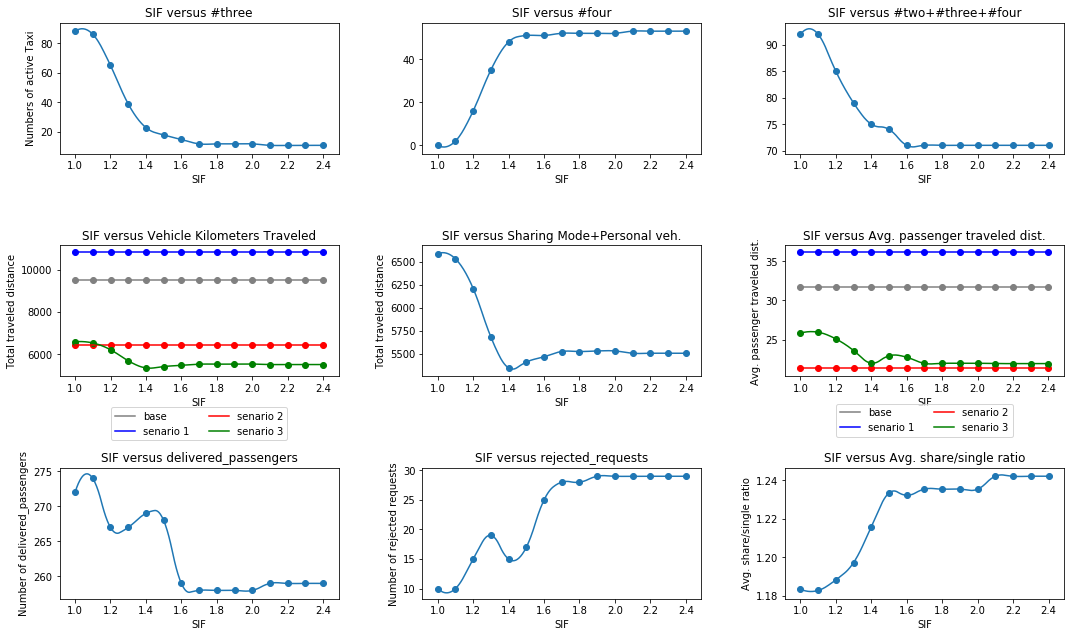

In [13]:
# <editor-fold desc="plot body">
# ==================================================================================================================plot
fig1, axes1 = plt.subplots(nrows=3, ncols=3, figsize=(18,10))
x = SIF_list
x_new = np.linspace(x.min(), x.max(), 300)

# plot SIF versus #three
y = np.array(Threes)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[0, 0].plot(x_new, y_smooth)
axes1[0, 0].scatter(x, y)
axes1[0, 0].set_title('SIF versus #three')
axes1[0, 0].set_xlabel('SIF', fontsize=10)
axes1[0, 0].set_ylabel('Numbers of active Taxi', fontsize=10)

# plot SIF versus #four
y = np.array(Fours)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[0, 1].plot(x_new, y_smooth)
axes1[0, 1].scatter(x, y)
axes1[0, 1].set_title('SIF versus #four')
axes1[0, 1].set_xlabel('SIF', fontsize=10)

# plot SIF versus (#two+#three+#four)
temp_list = np.array(Twos) + np.array(Threes) + np.array(Fours)
y = temp_list
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[0, 2].plot(x_new, y_smooth)
axes1[0, 2].scatter(x, y)
axes1[0, 2].set_title('SIF versus #two+#three+#four')
axes1[0, 2].set_xlabel('SIF', fontsize=10)

# plot SIF versus vkt
y0 = np.array(vkt_base)
f0 = interp1d(x, y0, kind='quadratic')
y_smooth0 = f0(x_new)
axes1[1, 0].plot(x_new, y_smooth0, label='base', c='grey')
axes1[1, 0].scatter(x, y0, c='grey')

y = np.array(vkt_single)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[1, 0].plot(x_new, y_smooth, label='senario 1', c='b')
axes1[1, 0].scatter(x, y, c='b')

y1 = np.array(vkt_without_comb)
f1 = interp1d(x, y1, kind='quadratic')
y_smooth1 = f1(x_new)
axes1[1, 0].plot(x_new, y_smooth1, label='senario 2', c='r')
axes1[1, 0].scatter(x, y1, c='r')

y2 = np.array(vkt_ShareSingle)
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes1[1, 0].plot(x_new, y_smooth2, label='senario 3',c='g')
axes1[1, 0].scatter(x, y2,c='g')

axes1[1, 0].set_title('SIF versus Vehicle Kilometers Traveled')
axes1[1, 0].set_xlabel('SIF', fontsize=10)
axes1[1, 0].set_ylabel('Total traveled distance', fontsize=10)
axes1[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# plot SIF versus (vkt_share+missing_rider+rejected_sum)
y = np.array(vkt_ShareSingle)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[1, 1].plot(x_new, y_smooth)
axes1[1, 1].scatter(x, y)
axes1[1, 1].set_title('SIF versus Sharing Mode+Personal veh.')
axes1[1, 1].set_xlabel('SIF', fontsize=10)
axes1[1, 1].set_ylabel('Total traveled distance', fontsize=10)

# plot SIF versus Avg. passenger traveled dist.
y0 = np.array(vkt_base)/No_riders
f0 = interp1d(x, y0, kind='quadratic')
y_smooth0 = f0(x_new)
axes1[1, 2].plot(x_new, y_smooth0, label='base', c='grey')
axes1[1, 2].scatter(x, y0, c='grey')

y = np.array(vkt_single)/No_riders
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[1, 2].plot(x_new, y_smooth,label='senario 1',c='b')
axes1[1, 2].scatter(x, y,c='b')

y1 = np.array(vkt_without_comb)/No_riders
f1 = interp1d(x, y1, kind='quadratic')
y_smooth1 = f1(x_new)
axes1[1, 2].plot(x_new, y_smooth1,label='senario 2',c='r')
axes1[1, 2].scatter(x, y1,c='r')

y2 = (np.array(vkt_Share)/np.array(riders) + np.array(vkt_rejected)/(No_riders-np.array(riders)))/2
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes1[1, 2].plot(x_new, y_smooth2,label='senario 3',c='g')
axes1[1, 2].scatter(x, y2, c='g')

axes1[1, 2].set_title('SIF versus Avg. passenger traveled dist.')
axes1[1, 2].set_xlabel('SIF', fontsize=10)
axes1[1, 2].set_ylabel('Avg. passenger traveled dist.', fontsize=10)
axes1[1, 2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2)


# plot SIF versus #Delivered_Riders
y = np.array(riders)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[2, 0].plot(x_new, y_smooth)
axes1[2, 0].scatter(x, y)
axes1[2, 0].set_title('SIF versus delivered_passengers')
axes1[2, 0].set_xlabel('SIF', fontsize=10)
axes1[2, 0].set_ylabel('Number of delivered_passengers', fontsize=10)

# plot SIF versus rejected_requests
y = np.array(rejected_request)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[2, 1].plot(x_new, y_smooth)
axes1[2, 1].scatter(x, y)
axes1[2, 1].set_title('SIF versus rejected_requests')
axes1[2, 1].set_xlabel('SIF', fontsize=10)
axes1[2, 1].set_ylabel('Number of rejected requests', fontsize=10)


# plot SIF versus Avg. share/single ratio
y = np.array(share_single_list)/np.array(riders)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes1[2, 2].plot(x_new, y_smooth)
axes1[2, 2].scatter(x, y)
axes1[2, 2].set_title('SIF versus Avg. share/single ratio')
axes1[2, 2].set_xlabel('SIF', fontsize=10)
axes1[2, 2].set_ylabel('Avg. share/single ratio', fontsize=10)

fig1.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7, wspace=0.3)
plt.show()
fig1.savefig(path+'plot.png', dpi=500)
ax.set_title('#Taxi: {0}, #Rider: {1}, solved in: {2} min'.
             format(No_Taxi, No_riders, round((End-Start)/60, 2)))
fig.savefig(path+'locations.png')
# </editor-fold>

#### plotly

In [14]:
# <editor-fold desc="plotly body">
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Number of active car-plotly
plotly.offline.init_notebook_mode(connected=True)
x = SIF_list
# plot SIF versus #two
trace2 = go.Scatter(x=x,
                    y=np.array(Twos),
                    mode='lines+markers',
                    name='SIF versus #two',
                    line=dict(shape='spline', smoothing=1.1))
# plot SIF versus #three
trace3 = go.Scatter(x=x,
                    y=np.array(Threes),
                    mode='lines+markers',
                    name='SIF versus #three',
                    line=dict(shape='spline', smoothing=1.1))
# plot SIF versus #four
trace4 = go.Scatter(x=x,
                    y=np.array(Fours),
                    mode='lines+markers',
                    name='SIF versus #four',
                    line=dict(shape='spline', smoothing=1.1))
# plot SIF versus (#two+#three+#four)
trace5 = go.Scatter(x=x,
                    y=np.array(Twos) + np.array(Threes) + np.array(Fours),
                    mode='lines+markers',
                    name='SIF versus #two+#three+#four',
                    line=dict(shape='spline', smoothing=1.1))

data = [trace2, trace3, trace4, trace5]
layout = go.Layout(
    title='<b>SIF versus taxis with 2, 3, 4 rider</b>',
    titlefont=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
    hovermode='closest',
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    xaxis=dict(title='SIF', zeroline=True, gridwidth=2),
    yaxis=dict(title='Numbers of active Taxi', zeroline=True, gridwidth=2),
    showlegend=True)

fig1 = go.Figure(data=data, layout=layout)
# plotly.offline.iplot(fig1)
plotly.offline.plot(fig1, filename=path+'active_taxi.html', auto_open=False)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++traveled distance-plotly
# plot SIF versus vkt_base
trace0 = go.Scatter(x=x,
                   y=np.array(vkt_base),
                   mode='lines+markers',
                   name='senario base',
                   line=dict(shape='spline', smoothing=1.1,color='rgb(153, 153, 153)'))
# plot SIF versus vkt_single
trace1 = go.Scatter(x=x,
                   y=np.array(vkt_single),
                   mode='lines+markers',
                   name='senario 1',
                   line=dict(shape='spline', smoothing=1.1,color='rgb(0, 0, 255)'))
# plot SIF versus (vkt_share+missing_rider+rejected_sum)
trace2 = go.Scatter(x=x,
                   y=np.array(vkt_without_comb),
                   mode='lines+markers',
                   name='senario 2',
                   line=dict(shape='spline', smoothing=1.1,color='rgb(255, 0, 0)'))
# plot SIF versus (vkt_share+missing_rider+rejected_sum)
trace3 = go.Scatter(x=x,
                   y=np.array(vkt_ShareSingle),
                   mode='lines+markers',
                   name='senario 3',
                   line=dict(shape='spline', smoothing=1.1,color='rgb(0, 255, 0)'))
data = [trace0,trace1, trace2, trace3]
layout = go.Layout(
    title='<b>SIF versus traveled distance</b>',
    titlefont=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
    hovermode='closest',
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    xaxis=dict(title='SIF', zeroline=True, gridwidth=2),
    yaxis=dict(title='Total traveled distance', zeroline=True, gridwidth=2),
    showlegend=True)

fig2 = go.Figure(data=data, layout=layout)
# plotly.offline.iplot(fig2)
plotly.offline.plot(fig2, filename=path+'vkt.html', auto_open=False)


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Avg. passenger traveled dist.
# plot SIF versus Avg. passenger traveled dist.
trace0 = go.Scatter(x=x,
                   y = np.array(vkt_base)/No_riders,
                   mode='lines+markers',
                   name='senario base',
                   line=dict(shape='spline', smoothing=1.1, color='rgb(153, 153, 153)'))
trace1 = go.Scatter(x=x,
                   y = np.array(vkt_single)/No_riders,
                   mode='lines+markers',
                   name='senario 1',
                   line=dict(shape='spline', smoothing=1.1, color='rgb(0, 0, 255)'))
trace2 = go.Scatter(x=x,
                   y = np.array(vkt_without_comb)/No_riders,
                   mode='lines+markers',
                   name='senario 2',
                   line=dict(shape='spline', smoothing=1.1, color='rgb(255, 0, 0)'))
trace3 = go.Scatter(x=x,
                   y = (np.array(vkt_Share)/np.array(riders) + np.array(vkt_rejected)/(No_riders-np.array(riders)))/2,
                   mode='lines+markers',
                   name='senario 3',
                   line=dict(shape='spline', smoothing=1.1, color='rgb(0, 255, 0)'))

data = [trace0,trace1,trace2,trace3]
layout = go.Layout(
    title='<b>SIF versus Avg. passenger traveled dist.</b>',
    titlefont=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
    hovermode='closest',
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    xaxis=dict(title='SIF', zeroline=True, gridwidth=2),
    yaxis=dict(title='Avg. passenger traveled dist.', zeroline=True, gridwidth=2),
    showlegend=True)

fig1 = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig1, filename=path+'Avg_traveled.html', auto_open=False)



# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#Riders-plotly
# plot SIF versus #delivered_riders
trace0 = go.Scatter(x=x,
                   y=np.array(riders),
                   mode='lines+markers',
                   name='SIF versus #delivered_riders',
                   line=dict(shape='spline', smoothing=1.1))
# plot SIF versus #rejected_request
trace1 = go.Scatter(x=x,
                   y=np.array(rejected_request),
                   mode='lines+markers',
                   name='SIF versus #rejected_request',
                   line=dict(shape='spline', smoothing=1.1))
data = [trace0, trace1]
layout = go.Layout(
    title='<b>SIF versus #delivered_riders & rejected_request</b>',
    titlefont=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
    hovermode='closest',
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    xaxis=dict(title='SIF', zeroline=True, gridwidth=2),
    yaxis=dict(title='Numbers of riders', zeroline=True, gridwidth=2),
    showlegend=True)

fig1 = go.Figure(data=data, layout=layout)
# plotly.offline.iplot(fig1)
plotly.offline.plot(fig1, filename=path+'riders.html', auto_open=False)



# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Avg. share/single ratio
# plot SIF versus Avg. share/single ratio
trace0 = go.Scatter(x=x,
                   y=np.array(share_single_list)/np.array(riders),
                   mode='lines+markers',
                   name='SIF versus Avg. share/single ratio',
                   line=dict(shape='spline', smoothing=1.1))
data = [trace0]
layout = go.Layout(
    title='<b>SIF versus Avg. share/single ratio</b>',
    titlefont=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
    hovermode='closest',
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    xaxis=dict(title='SIF', zeroline=True, gridwidth=2),
    yaxis=dict(title='Avg. share/single ratio', zeroline=True, gridwidth=2),
    showlegend=True)

fig1 = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig1, filename=path+'share_single.html', auto_open=False)



# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++location-plotly
# plot riders in origin
xo, yo = zip(*list(riders_O.values()))
zo = []
for i in generator(0, len(list(riders_O.values()))):
    Sum = sum([1 if j == list(riders_O.values())[i] else 0 for j in list(riders_O.values())[:i]])
    zo.append(Sum)
trace0 = go.Scatter3d(x=xo,
                     y=yo,
                     z=zo,
                     text=list(riders_O.keys()),
                     textfont=dict(size=8),
                     mode='markers+text',
                     marker=dict(color='#00bfff', size=3, symbol='circle', line=dict(color='#0000ff', width=1), opacity=0.9),
                     textposition='top center',
                     name='Riders in Origin')

# plot riders in destination
xd, yd = map(list, zip(*list(riders_D.values())))
zd = []
for i in generator(0, len(list(riders_D.values()))):
    Sum = sum([1 if j == list(riders_D.values())[i] else 0 for j in list(riders_D.values())[:i]])
    zd.append(Sum)
trace1 = go.Scatter3d(x=xd,
                     y=yd,
                     z=zd,
                     text=list(riders_D.keys()),
                     textfont=dict(size=8),
                     mode='markers+text',
                     marker=dict(color='#faaa0a', size=3, symbol='circle', line=dict(color='#9400d3', width=1), opacity=0.8),
                     name='Riders in Destination')

# plot taxis
xt, yt = map(list, zip(*list(Taxis.values())))
zt = []
for i in generator(0, len(list(Taxis.values()))):
    Sum = sum([1 if j == list(Taxis.values())[i] else 0 for j in list(Taxis.values())[:i]])
    zt.append(Sum)
trace2 = go.Scatter3d(x=xt,
                     y=yt,
                     z=zt,
                     text=list(Taxis.keys()),
                     textfont=dict(size=8),
                     mode='markers+text',
                     marker=dict(color='#800080', size=3, symbol='x', line=dict(color='#fa00fa', width=1), opacity=0.8),
                     name='Taxi')
data = [trace0, trace1, trace2]
layout = go.Layout(
    title='Taxi: {0}, riders: {1}, solved in: {2} min'.format(No_Taxi, No_riders, round((End-Start)/60, 2)),
    titlefont=dict(family='Comic Sans MS', size=8, color='rgb(60, 60, 60)'),
    margin=dict(r=0, b=0, l=0, t=0),
    legend=dict(x=1, y=.5, traceorder='normal', font=dict(family='Courier', size=15, color='#000'),
                bgcolor='#FFFFFF', bordercolor='#E2E2E2', borderwidth=2),
    scene=dict(xaxis=dict(tickfont=dict(size=12), backgroundcolor="#c8c8e6", gridcolor="#ffffff", showbackground=True,
                          zerolinecolor="#ffffff"),
               yaxis=dict(tickfont=dict(size=12), backgroundcolor="#e6c8e6", gridcolor="#ffffff", showbackground=True,
                          zerolinecolor="#ffffff"),
               zaxis=dict(tickfont=dict(size=12), backgroundcolor="#e6e6c8", gridcolor="#ffffff", showbackground=True,
                          zerolinecolor="#ffffff"),
               dragmode="turntable",
               annotations=[dict(showarrow=True, z=3, text='<b>Taxi: {0}, riders: {1}, solved in: {2} min</b>'.
                                 format(No_Taxi, No_riders, round((End-Start)/60, 2)), textangle=0,
                                 font=dict(family='Comic Sans MS', size=18, color='#3c3c3c'),
                                 arrowcolor="rgba(255, 255, 255, .1)", ax=0, ay=-100)]  # rgba(255,255,255,0.1)=#fafafa
               )
)
fig3 = go.Figure(data=data, layout=layout)
# plotly.offline.iplot(fig3)
plotly.offline.plot(fig3, filename=path+'location.html', auto_open=False)




html_graphs = open(path+"DASHBOARD.html", 'w')
html_graphs.write("<html><head></head><body>"+"\n")
html_graphs.write("<object data='location.html' width='900' height='700'></object>"+"\n")
html_graphs.write("<object data='active_taxi.html' width='1100' height='800'></object>"+"\n")
html_graphs.write("<object data='vkt.html' width='1100' height='800'></object>"+"\n")
html_graphs.write("<object data='Avg_traveled.html' width='1100' height='800'></object>"+"\n")
html_graphs.write("<object data='riders.html' width='1100' height='800'></object>"+"\n")
html_graphs.write("<object data='share_single.html' width='1100' height='800'></object>"+"\n")
html_graphs.write("</body></html>")
html_graphs.close()
# </editor-fold>

#### clustering


round:  1

round:  2

round:  3

round:  4

round:  5

round:  6

round:  7

done!                      : break


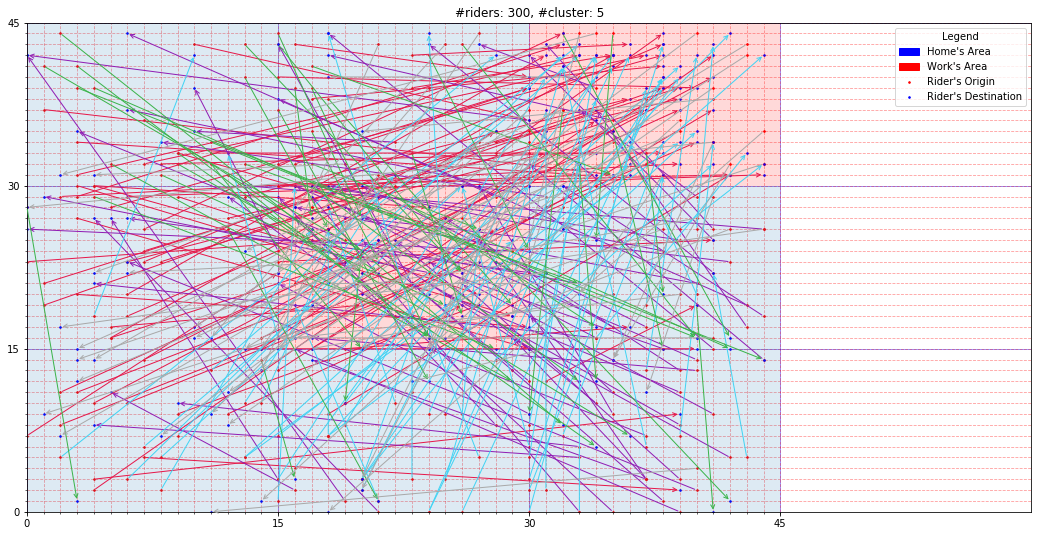

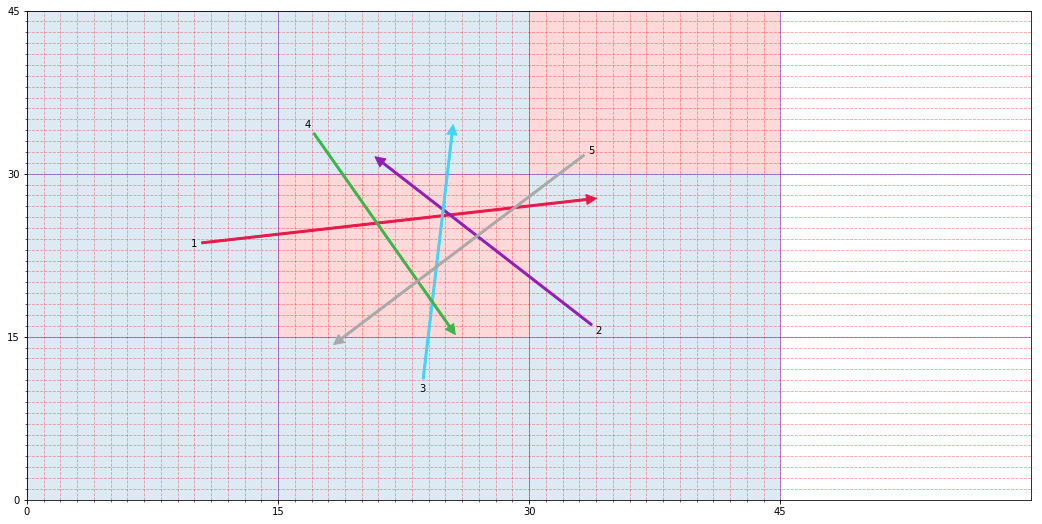

In [15]:
# ----------------------------------------------------------------------------------------------------------------------
#                                                        Plotting
# ----------------------------------------------------------------------------------------------------------------------
fig_arrow, ax_arrow = plt.subplots(figsize=(18,9))
fig_cluster, ax_cluster = plt.subplots(figsize=(18,9))
alpha = [1.9, .6, .25, .15]
patterns = ['+', 'x', '-']
for each_area in generator(1, 10):
    if each_area == 5 or each_area == 9:
        x, y, w, h = Work["w{0}".format(each_area)][0][0], \
                     Work["w{0}".format(each_area)][1][0], \
                     Work["w{0}".format(each_area)][0][1] - Work["w{0}".format(each_area)][0][0], \
                     Work["w{0}".format(each_area)][1][1] - Work["w{0}".format(each_area)][1][0]
        rect = patches.Rectangle((x, y), w, h, facecolor='red', alpha=alpha[3], )
        new_rect = copy.copy(rect)
        ax_arrow.add_patch(rect)
        ax_cluster.add_patch(new_rect)
    else:
        x, y, w, h = Home["h{0}".format(each_area)][0][0], \
                     Home["h{0}".format(each_area)][1][0], \
                     Home["h{0}".format(each_area)][0][1]-Home["h{0}".format(each_area)][0][0], \
                     Home["h{0}".format(each_area)][1][1]-Home["h{0}".format(each_area)][1][0]
        rect = patches.Rectangle((x, y), w, h, alpha=alpha[3], )
        new_rect = copy.copy(rect)
        ax_arrow.add_patch(rect)
        ax_cluster.add_patch(new_rect)


ax_arrow.axis([0, 60, 0, 45])
ax_arrow.minorticks_on()
ax_cluster.axis([0, 60, 0, 45])
ax_cluster.minorticks_on()

ax_arrow.grid(b=True, which="minor", linestyle="--", color='r', alpha=0.4)
ax_arrow.grid(b=True, which="major", linestyle="-", linewidth=1, color="b", alpha=0.4)
ax_cluster.grid(b=True, which="minor", linestyle="--", color='r', alpha=0.4)
ax_cluster.grid(b=True, which="major", linestyle="-", linewidth=1, color="b", alpha=0.4)

ax_arrow.set_axisbelow(True)
ax_arrow.set_xticks(np.arange(0, 46, 15))
ax_arrow.set_yticks(np.arange(0, 46, 15))
ax_arrow.set_xticks(np.arange(0, 46, 1), minor=True)
ax_arrow.set_yticks(np.arange(0, 46, 1), minor=True)

ax_cluster.set_axisbelow(True)
ax_cluster.set_xticks(np.arange(0, 46, 15))
ax_cluster.set_yticks(np.arange(0, 46, 15))
ax_cluster.set_xticks(np.arange(0, 46, 1), minor=True)
ax_cluster.set_yticks(np.arange(0, 46, 1), minor=True)

blue_patch = patches.Patch(color='blue', label="Home's Area")
red_patch = patches.Patch(color='red', label="Work's Area")
red_dot = ax_arrow.scatter(*zip(*list(Riders_O.values())), marker='.', c='r', s=10, label="Rider's Origin")
blue_dot = ax_arrow.scatter(*zip(*list(riders_D.values())), marker='.', c='blue', s=10, label="Rider's Destination")

ax_arrow.legend(handles=[blue_patch, red_patch, red_dot, blue_dot], loc='best', title='Legend')
ax_arrow.set_title('#riders: {0}, #cluster: {1}'.format(No_riders,number_of_clusters))



# Copy main dictionaries for using next for loops (SIF)
riders_O_copy, riders_D_copy = riders_O.copy(), riders_D.copy()


checker = [False]
while False in checker:
    '''
    selecting centroid randomly;
    checking the angle between them is larger than (360/(number_of_clusters+1))
    '''
    clustering_on_the_basis_of = list(np.random.choice(list(riders_O_copy.keys()), number_of_clusters,
                                                       replace=False))
    checker = list(map(lambda each_comb:
                       True if find_angles(find_angle(riders_O_copy[each_comb[0]], 
                                                      riders_D_copy[re.sub(r'o','d',each_comb[0])]),
                                           find_angle(riders_O_copy[each_comb[1]], 
                                                      riders_D_copy[re.sub(r'o','d',each_comb[1])])
                                           ) > (360/(number_of_clusters+1)) else False,
                       itertools.combinations(clustering_on_the_basis_of, 2)
                       )
                   )
clustering_on_the_basis_of.sort(key=lambda x: int(x[2:]))
# print(clustering_on_the_basis_of)

before_clustering_dic_Temp = {}
counter = 0
while True:
    '''
    
    '''    
    counter += 1
    print('\n{0} {1}'.format('round: ', counter))
    clustering_dic_Temp = {i: list() for i in range(1, number_of_clusters + 1)}
    for each_person in list(riders_O.keys()):
        
        '''
        calculating angle between each rider and all centroids and store in each_person_over_clusters
        '''
        each_person_over_clusters = dict()
        for each_cluster_id in clustering_on_the_basis_of:
            angle_anti_person = find_angle(riders_O_copy[each_person],riders_D_copy[re.sub(r'o','d',each_person)])
            angle_anti_cluster = find_angle(riders_O_copy[each_cluster_id],riders_D_copy[re.sub(r'o','d',each_cluster_id)])
            angle_person_cluster = find_angles(angle_anti_person,angle_anti_cluster)
            each_person_over_clusters[each_cluster_id] = angle_person_cluster
        
        min_clus = min(each_person_over_clusters, key=each_person_over_clusters.get)
        min_clus_index = clustering_on_the_basis_of.index(min_clus)+1
        clustering_dic_Temp[min_clus_index].append(each_person)


#     print('\n{0:27}: {1}'.format('clustering_on_the_basis_of', clustering_on_the_basis_of))
#     print('{0:27}: {1}'.format('before_clustering_dic_Temp', before_clustering_dic_Temp))
#     print('{0:27}: {1}'.format('clustering_dic_Temp', clustering_dic_Temp))
#     print('{0:27}: {1}'.format('riders_O_copy', riders_O_copy))
#     print('{0:27}: {1}'.format('riders_D_copy', riders_D_copy))

    if clustering_dic_Temp == before_clustering_dic_Temp:
        print('\n{0:27}: {1}'.format('done!', 'break'))
        break
    
    '''
    update centroid and calculating new one
    '''
    for each_cluster in clustering_dic_Temp:
        if len(clustering_dic_Temp[each_cluster]) == 1:
            continue

        for index_line in range(0, len(clustering_dic_Temp[each_cluster])):
            '''
            calculating bisector_angle of first two member
            and then calculating the coordinates of that bisector_angle 
            and store in the temp_end_point
            '''
            rider_id_in_clus = clustering_dic_Temp[each_cluster][index_line]
            if index_line == 0:
                rider_id_in_clus_plus1 = clustering_dic_Temp[each_cluster][index_line + 1]
                # temp_end_point keep end point of bisector line for 2 lines
                temp_end_point = bisector_line((0, 0),
                                               bisector_angle(riders_O_copy[rider_id_in_clus],
                                                              riders_D_copy[re.sub(r'o', 'd', rider_id_in_clus)],
                                                              riders_O_copy[rider_id_in_clus_plus1],
                                                              riders_D_copy[re.sub(r'o', 'd', rider_id_in_clus_plus1)]
                                                             ),
                                               2)
            elif index_line == 1:
                pass
            else:
                '''
                we have bisector of two first-order member from above
                now we'll find the bisector of that (above) with the rest of the centroid's member
                '''
                temp_end_point = bisector_line((0, 0),
                                               bisector_angle((0,0),
                                                              temp_end_point,
                                                              riders_O_copy[rider_id_in_clus],
                                                              riders_D_copy[re.sub(r'o', 'd', rider_id_in_clus)]
                                                             ),
                                               2)

        # update
        '''
        Now store the new centroid, whose coordinates are stored in the temp_end_point, 
        in clustering_on_the_basis_of
        '''
        new_cluster = 'poc{}'.format(each_cluster)
        clustering_on_the_basis_of[each_cluster-1] = new_cluster
        riders_O_copy[new_cluster] = (0,0)
        riders_D_copy[re.sub(r'o','d',new_cluster)] = temp_end_point
    before_clustering_dic_Temp = clustering_dic_Temp

'''
calculating counter-clockwise angle of each final centroid
'''
final_com_angle = [find_angle(i[0],i[1]) 
                   for i in [(riders_O_copy[i], riders_D_copy[re.sub(r'o','d',i)]) 
                             for i in clustering_on_the_basis_of]]


'''
finding center of oring and destination points
'''
final_origin_loc = [[riders_O_copy[o] for o in clustering_dic_Temp[each_clus]] 
                    for each_clus in clustering_dic_Temp]
final_dest_loc = [[riders_D_copy[re.sub(r'o','d',d)]  for d in clustering_dic_Temp[each_clus]] 
                  for each_clus in clustering_dic_Temp]
final_origin_loc_com = list(map(lambda loc_list: 
                                tuple(np.array(loc_list).mean(axis=0)) 
                                if len(loc_list)!=0 else False, final_origin_loc))
final_dest_loc_com = list(map(lambda loc_list: 
                              tuple(np.array(loc_list).mean(axis=0)) 
                              if len(loc_list)!=0 else False, final_dest_loc))


'''
plot the final clusters

for origin: final_origin_loc_com
for destination: final_dest_loc_com_

to implementing angle, we should recalculate center of destinations
'''
final_dest_loc_com_ = []
for xyo, xyd, angle in zip(final_origin_loc_com, final_dest_loc_com, final_com_angle):
    if not xyo:
        final_dest_loc_com_.append(False)
        continue
    final_dest_loc_com_.append(bisector_line(xyo, angle, sqrt((xyo[0]-xyd[0])**2+(xyo[1]-xyd[1])**2)))


# print('{0:27}: {1}'.format('final_com_angle', final_com_angle))  
# print('{0:27}: {1}'.format('final_origin_loc', final_origin_loc))
# print('{0:27}: {1}'.format('final_dest_loc', final_dest_loc))
# print('{0:27}: {1}'.format('final_origin_loc_com', final_origin_loc_com))
# print('{0:27}: {1}'.format('final_dest_loc_com', final_dest_loc_com))    
# print('{0:27}: {1}'.format('final_dest_loc_com_', final_dest_loc_com_))



Color = ['#e6194B', '#911eb4', '#42d4f4', '#3cb44b', '#a9a9a9', '#f58231', '#ffe119', '#bfef45', '#4363d8', '#f032e6']
# plotting the riders
for cluster, color_hex in zip(clustering_dic_Temp, Color):
    if not clustering_dic_Temp[cluster]:
        continue
    for po in clustering_dic_Temp[cluster]:
        ax_arrow.annotate("", xytext=riders_O_copy[po], xy=riders_D_copy[re.sub(r'o','d',po)], 
                          arrowprops=dict(color=color_hex, arrowstyle="->"))

# plotting representative clusters
for xyo, xyd, color_hex in zip(final_origin_loc_com, final_dest_loc_com_, Color):
    if not xyo:
        continue
    ax_cluster.annotate(final_origin_loc_com.index(xyo)+1, xytext=xyo, xy=xyd, 
                        arrowprops=dict(color=color_hex, arrowstyle="simple, head_width=1, head_length=1"))


fig_arrow.savefig(path+'fig_arrow.png')
fig_cluster.savefig(path+'fig_cluster.png')
plt.show()
